In [16]:
import numpy as np
import matplotlib.pyplot as plt
from operator import add

np.set_printoptions(precision = 3, suppress = True)

In [17]:
# vanilla RSA adapted from seminar's RSA model
## My changes:
## Changed constructor to include truth_table
## Removed L0_truth_table() (now implemented in constructor)
## Allowed for different objects and messages as well as different numbers of each
## Allowed for different truth tables

## note to self: barebones for now -- docstrings, more exceptions would be nice

class RSAModel():
    def __init__(self, objects, messages, truth_table, alpha, prior_o, cost_function):
        if np.shape(truth_table) != (len(messages),len(objects)):
          raise ValueError("""Truth matrix must be m x n, 
          where m is number of messages and n is the number of objects""")
        self.objects = objects
        self.messages = messages
        self.truth_table = truth_table
        self.alpha = alpha
        self.prior_o = prior_o
        self.cost_function = cost_function
        
        # the following are for convenience
        self.n_obj = len(self.objects)
        self.n_mes = len(self.messages)
    
    def normalize(self, arr):
        return arr / arr.sum(axis=1)[:, np.newaxis]
    
    def L0(self):
        #compute [[m]](o): literal meaning
        literal_meaning = self.truth_table

        #P(o) -- create a matrix of priors by repeating the priors array for each row
        prior_o = np.tile(np.array(self.prior_o), (self.n_mes,1))

        #multiply the two of L0 terms together
        unnorm  =  literal_meaning * prior_o

        #normalize to obtain a probability distribution
        norm = self.normalize(unnorm)

        return norm
    
    def S1(self):
        #compute the costs for each expression in self.messages
        costs = self.cost_function()

        #utility without costs
        epsilon = 1e-10 # to prevent log(0)
        raw_utility = np.log(self.L0().T + epsilon)

        #Cost(m) -- reshape to obtain correct dimensions for matrix multiplication
        costs = np.repeat(self.cost_function(),2).reshape((self.n_mes, self.n_obj)).T

        #compute utility by subtracting costs from informativity
        utility = np.subtract(raw_utility,costs)

        #compute S1(m|o) by taking the exponent of utility times the temperature parameter alpha
        unnorm = np.exp(self.alpha*utility)

        #normalize to obtain a probability distribution
        norm = self.normalize(unnorm)

        return norm
    
    def L1(self):
        #S1(m|o)
        S1 = self.S1()
        
        #P(o) -- create a matrix of priors by repeating the priors array for each row
        prior_o = np.tile(np.array(self.prior_o), (self.n_mes, 1)) 

        #multiply S1(m|o) (transformed, since we need a distribution over objects, not over messages) and P(o) together
        unnorm = S1.T * prior_o

        #normalize to obtain a probability distribution
        norm = self.normalize(unnorm)

        return norm
    
    def plot(self):
        L1 = self.L1()
        fig, ax = plt.subplots(self.n_mes)
        for i, message in enumerate(self.messages):
            ax[i].bar(self.objects, L1[i,:])
            ax[i].set_title(f"L1 probability for objects given message '{message}'")
            ax[i].set_xlabel('Objects')
            ax[i].set_ylabel('Probability')
            ax[i].set_ylim([0,1])
        plt.tight_layout()
        plt.show()

# Vanilla model
### In this example, we create a model using a zero cost function (i.e. all utterances have zero cost), boolean truth matrices (i.e. unweighted matrices) and uniform priors over objects

In [18]:
# Example of vanilla model
objects = ['greyhound','dalmatian']
messages = ['dog','greyhound','dalmatian']
truth_table = np.array([[1,1,0],[1,0,1]]).T
prior_o = [0.5,0.5]
alpha = 0.8

def cost_function(): # we'll need to figure this out later
    return [0,0,0]

vanilla = RSAModel(objects, messages, truth_table, alpha, prior_o ,cost_function)

In [19]:
# vanilla L0
vanilla.L0()

array([[0.5, 0.5],
       [1. , 0. ],
       [0. , 1. ]])

In [20]:
# vanilla S1
vanilla.S1()

array([[0.365, 0.635, 0.   ],
       [0.365, 0.   , 0.635]])

In [21]:
# vanilla L1
vanilla.L1()

array([[0.5, 0.5],
       [1. , 0. ],
       [0. , 1. ]])

# Option 1: Modify S1 by adding a prior probability of utterances
### Here, we modify the S1 equation by adding a prior probability over messages $P(m)$, resulting in following equation: <br>$$ S_{1}(m|o) \propto exp(\alpha \cdot U(m;o)) P(m)$$ <br> This is a flexible tool, but in the context of this project, the main utility is that we can choose a different prior over messages for natives and non-natives, i.e. $P(m|l)$, where $l = 1$ if the speaker is native else $l = 0$. A more fine-grained approach could change $l$ to a continuous variable representing the level of the non-native speaker. <br> The motivation here is that now the pragmatic listener can calculate the probability of the speaker saying message $m$ based on whether they are a native-speaker. For example, we can make less common words be less probable if the speaker is non-native if the pragmatic listener thinks the speaker probably does not know them.

In [22]:
class RSAModelWithPriorOverUtterances(RSAModel):
    def __init__(self, objects, messages, truth_table, alpha, prior_o, prior_m, cost_function):
        super().__init__(objects, messages, truth_table, alpha, prior_o, cost_function)
        self.prior_m = prior_m
    
    def S1(self):
        #compute the costs for each expression in self.messages
        costs = self.cost_function()

        #utility without costs
        epsilon = 1e-10 # to prevent log(0)
        raw_utility = np.log(self.L0().T + epsilon)

        #Cost(m) -- reshape to obtain correct dimensions for matrix multiplication
        costs = np.repeat(self.cost_function(),2).reshape((self.n_mes, self.n_obj)).T

        #compute utility by subtracting costs from informativity
        utility = np.subtract(raw_utility,costs)
        
        #compute P(m|o) by taking the exponent of utility times the temperature parameter alpha
        unnorm = np.exp(self.alpha*utility)
        
        #P(m): prior over messages
        prior = np.tile(np.array(self.prior_m), (self.n_obj,1))
        
        #weigh P(m|o) according to P(m)
        weighted = unnorm * prior
        
        #normalize to obtain a probability distribution
        norm = self.normalize(weighted)

        return norm
    
    @property
    def prior_m(self):
        return self._prior_m
    
    @prior_m.setter
    def prior_m(self, prior_m):
        if len(prior_m) == self.n_mes:
            self._prior_m = prior_m
        else:
            raise ValueError('Length of prior_m must equal the number of messages')

## Native speaker
### Below we can see L0, S1 and L1 when the speaker is native. For the prior over messages, I choose a uniform distribution for the native speaker, with the idea that the native speaker is equally likely to know all the messages. Consequentially, the results are, of course, the same as in the vanilla model.

In [23]:
prior_m_native = np.ones(3) / 3 # i.e. uniform
RSAOption1_native = RSAModelWithPriorOverUtterances(objects, messages, truth_table, alpha, 
                                                    prior_o ,prior_m_native, cost_function)
print(RSAOption1_native.L0())
print(RSAOption1_native.S1())
print(RSAOption1_native.L1())

[[0.5 0.5]
 [1.  0. ]
 [0.  1. ]]
[[0.365 0.635 0.   ]
 [0.365 0.    0.635]]
[[0.5 0.5]
 [1.  0. ]
 [0.  1. ]]


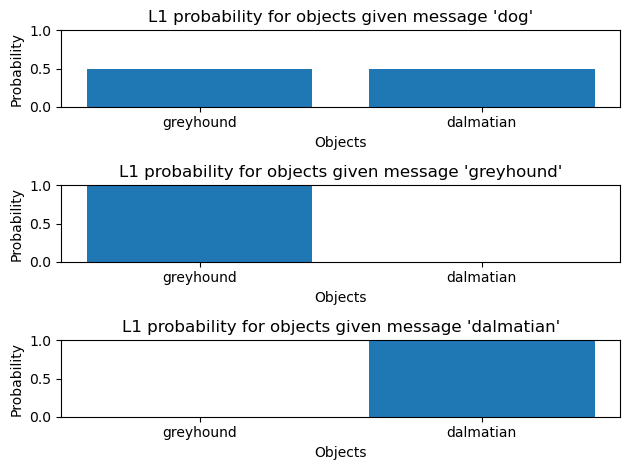

In [24]:
RSAOption1_native.plot()

## Non-native speaker
### Below we can see the same for when the speaker is non-native. Let's say for whatever reason, they are equally likely to know 'dog' and 'dalmation', but half as likely as either to know 'greyhound.' As desired, 'dog' is more likely to refer to the 'greyhound' because the speaker has to fall back to saying 'dog' in absence of knowing the word 'greyhound.'

In [25]:
prior_m_nonnative = [0.4,0.2,0.4]
RSAOption1_nonnative = RSAModelWithPriorOverUtterances(objects, messages, truth_table, alpha, 
                                                    prior_o ,prior_m_nonnative, cost_function)


In [26]:
print(RSAOption1_nonnative.L0())
print(RSAOption1_nonnative.S1())
print(RSAOption1_nonnative.L1())

[[0.5 0.5]
 [1.  0. ]
 [0.  1. ]]
[[0.535 0.465 0.   ]
 [0.365 0.    0.635]]
[[0.594 0.406]
 [1.    0.   ]
 [0.    1.   ]]


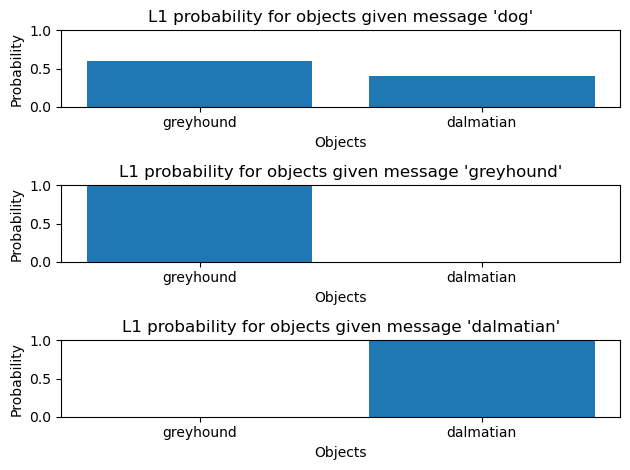

In [27]:
RSAOption1_nonnative.plot()

# Underspecification in a binary example
### Here we compare the interpretation of the messages 'dog' and 'greyhound' in reference to the two objects, a generic dog and a greyhound

/var/folders/6g/v4dn3hc95x1cy5j6qz2c4t6r0000gn/T/ipykernel_8139/1186882578.py:16: RuntimeWarning: divide by zero encountered in log
  prior_greyhound_logits.append(np.log(prior[1] / (prior[0] + 1e-10)))
/var/folders/6g/v4dn3hc95x1cy5j6qz2c4t6r0000gn/T/ipykernel_8139/1899488027.py:27: RuntimeWarning: invalid value encountered in true_divide
  return arr / arr.sum(axis=1)[:, np.newaxis]


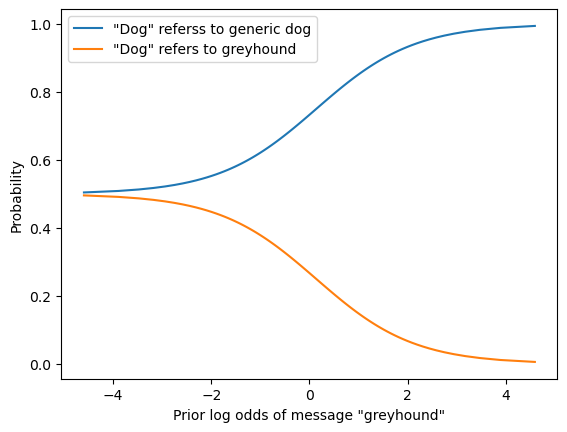

In [28]:
more_objects = ['generic dog','greyhound']
more_messages = ['dog','greyhound']
more_truth_table = np.array([[1,1],[0,1]])
uniform = [0.5,0.5]

def more_cost_function():
    return [0,0]

RSAModelEx = RSAModelWithPriorOverUtterances(more_objects, more_messages, more_truth_table, 
                                             alpha, uniform, uniform, more_cost_function)
greyhound_probs = []
dog_probs = []
prior_greyhound_logits = [] # the prior log odds of saying greyhound 
for i in np.arange(0,1,0.01):
    prior = np.array([1-i, i]) # prior over messages
    prior_greyhound_logits.append(np.log(prior[1] / (prior[0] + 1e-10)))
    RSAModelEx.prior_m = prior # update prior
    L1 = RSAModelEx.L1() # calculate new L1
    greyhound_probs.append(L1[0,1]) # i.e. the probability that 'dog' refers to the greyhound
    dog_probs.append(L1[0,0])
    
fig, ax = plt.subplots()
ax.plot(prior_greyhound_logits, dog_probs, label = '"Dog" referss to generic dog')
ax.plot(prior_greyhound_logits, greyhound_probs, label = '"Dog" refers to greyhound')
ax.set_xlabel('Prior log odds of message "greyhound"')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

# Model progression: native vs. nonnative


In [29]:
m1 = RSAModelWithPriorOverUtterances(objects, messages, truth_table, alpha, 
                                                    prior_o, prior_m_native, cost_function)
m2 = RSAModelWithPriorOverUtterances(objects, messages, truth_table, alpha, 
                                                    prior_o, prior_m_nonnative, cost_function)

# m1 results
m1_l0 = m1.L0()
m1_s1 = m1.S1()
m1_l1 = m1.L1()

# m2 results
m2_l0 = m2.L0()
m2_s1 = m2.S1()
m2_l1 = m2.L1()

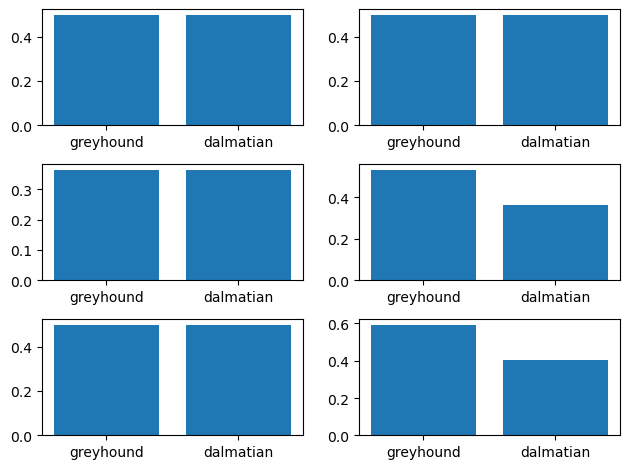

In [36]:
fig, ax = plt.subplots(3,2)

# m1 plots
ax[0][0].bar(objects,m1_l0[0,:])
ax[1][0].bar(objects,m1_s1[:,0])
ax[2][0].bar(objects,m1_l1[0,:])

# m2 plots
ax[0][1].bar(objects,m2_l0[0,:])
ax[1][1].bar(objects,m2_s1[:,0])
ax[2][1].bar(objects,m2_l1[0,:])

plt.tight_layout()
plt.show()